In [2]:
# YouTube API 데이터 추출 후 JSON 저장
import json
import pandas as pd
import googleapiclient.discovery
from dotenv import dotenv_values


import json
import pandas as pd
import googleapiclient.discovery
from dotenv import dotenv_values


def get_api_key():
    ''' 
    Youtube API Key
    '''
    config = dotenv_values(".env")
    return config['API_KEY']


# total comments
total_data = []


def get_data(count=999999, nextPageToken=""):
    '''
    Change YOUR_API_KEY!!!
    Recursively receive data as much as maxResults through API. 
    Limit API calls to count parameter.
    '''
    # Check count
    if count < 1:
        print("[INFO] Count End.")
        return

    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    # os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = get_api_key()  # "YOUR_API_KEY"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    # Document reference
    # example >> part="id, snippet, replies", maxResults=20, order="relevance", pageToken=nextPageToken, videoId="HNObBsbvxOk",
    request = youtube.commentThreads().list(
        part="id, snippet, replies",
        maxResults=100,
        order="relevance",
        pageToken=nextPageToken,
        videoId="Bb5DKSx5jTI",
    )
    response = request.execute()

    print(f"************** {count} times left. **************")

    # print(response)

    # append response to total_data
    total_data.append(response)

    # Call recursive when nextPageToken is exist.
    if "nextPageToken" in response:
        get_data(count-1, response["nextPageToken"])
    else:
        print("[End] No more comments.")

In [ ]:
def save_response_to_json_file(filepath):
    # save response to JSON file.
    json_data = {"responses": total_data}
    with open(filepath, 'w', encoding='utf-8') as make_file:
        json.dump(json_data, make_file, indent="\t", ensure_ascii=False)
        print("[INFO] JSON file Saved.")


def open_json_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        json_file = json.load(f)
    return json_file

In [3]:
# JSON 데이터에서 원하는 정보만 추출하여 pandas 후 csv로 저장
def json_file_to_pandas_csv(json_file, filepath):
    print("[INFO] JSON to Pandas Started.")
    json_responses = json_file["responses"]

    videoId = []
    item_type = []  # 0: comment, 1: replie
    textDisplay = []
    textOriginal = []
    authorDisplayName = []
    authorChannelUrl = []
    likeCount = []
    # isBad = []

    for json_data in json_responses:
        items = json_data["items"]

        for item in items:
            comment_videoId = item["snippet"]["videoId"]
            comment_textDisplay = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comment_textOriginal = item["snippet"]["topLevelComment"]["snippet"]["textOriginal"]
            comment_authorDisplayName = item["snippet"]["topLevelComment"]["snippet"]["authorDisplayName"]
            comment_authorChannelUrl = item["snippet"]["topLevelComment"]["snippet"]["authorChannelUrl"]
            comment_likeCount = item["snippet"]["topLevelComment"]["snippet"]["likeCount"]
            comment_totalReplyCount = item["snippet"]["totalReplyCount"]

            videoId.append(comment_videoId)
            item_type.append(0)
            textDisplay.append(comment_textDisplay)
            textOriginal.append(comment_textOriginal)
            authorDisplayName.append(comment_authorDisplayName)
            authorChannelUrl.append(comment_authorChannelUrl)
            likeCount.append(comment_likeCount)

            if comment_totalReplyCount != 0:
                replies = item["replies"]["comments"]

                for replie in replies:
                    replie_videoId = replie["snippet"]["videoId"]
                    replie_textDisplay = replie["snippet"]["textDisplay"]
                    replie_textOriginal = replie["snippet"]["textOriginal"]
                    replie_authorDisplayName = replie["snippet"]["authorDisplayName"]
                    replie_authorChannelUrl = replie["snippet"]["authorChannelUrl"]
                    replie_likeCount = replie["snippet"]["likeCount"]

                    videoId.append(replie_videoId)
                    item_type.append(1)
                    textDisplay.append(replie_textDisplay)
                    textOriginal.append(replie_textOriginal)
                    authorDisplayName.append(replie_authorDisplayName)
                    authorChannelUrl.append(replie_authorChannelUrl)
                    likeCount.append(replie_likeCount)

    data = {'videoId': videoId, 'item_type': item_type, 'authorDisplayName': authorDisplayName,
            'textDisplay': textDisplay, 'textOriginal': textOriginal, 'authorChannelUrl': authorChannelUrl, 'likeCount': likeCount}

    df = pd.DataFrame(data)
    # df["category"] = "game"
    df["isBad"] = 0
    # print(df.tail())

    print("[INFO] JSON to Pandas Finished.")
    df.to_csv(filepath)
    print("[INFO] CSV File save Finished.")

,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,isBad
0,EB2wH1_B_7A,0,뇌피소설가 입소문tv,ㅇㄹㅈㅂㅅㅎㅈ 초성정답,ㅇㄹㅈㅂㅅㅎㅈ 초성정답,http://www.youtube.com/channel/UChpiLQ5R0TYR9O...,65,0
1,EB2wH1_B_7A,1,안용호,오 예측성공,오 예측성공,http://www.youtube.com/channel/UCsgdLLQoAN5RoY...,0,0
2,EB2wH1_B_7A,1,경이로운 쿠키,이거 17회에요,이거 17회에요,http://www.youtube.com/channel/UCis3ExhHkhEvJE...,0,0
3,EB2wH1_B_7A,1,까페모카,아아~,아아~,http://www.youtube.com/channel/UCpcR4qXlzGEAZs...,1,0
4,EB2wH1_B_7A,1,이민호,지하 금불상...딜 아닐까요?,지하 금불상...딜 아닐까요?,http://www.youtube.com/channel/UCaFvZHUQn-S5OX...,3,0
...,...,...,...,...,...,...,...,...
166,EB2wH1_B_7A,0,강신조,인터폴이 훼이크,인터폴이 훼이크,http://www.youtube.com/channel/UCFocoqPhfHroXu...,0,0
167,EB2wH1_B_7A,0,경이로운 쿠키,18회예상해봤을때는 장한서랑 빈센조랑 짜고 총을쏘는 척 을 한다음 빈센조가 병원에 ...,18회예상해봤을때는 장한서랑 빈센조랑 짜고 총을쏘는 척 을 한다음 빈센조가 병원에 ...,http://www.youtube.com/channel/UCis3ExhHkhEvJE...,1,0
168,EB2wH1_B_7A,0,ej RYU,잘 봤어요~ 감사합니다,잘 봤어요~ 감사합니다,http://www.youtube.com/channel/UC9kpxtJ5PMjnBZ...,0,0
169,EB2wH1_B_7A,0,임요셉,ㄹㅇ 빼박임 ㅋㅋㅋㅎㅎㅋㅋㅋㅎㅋ 작가 의도가 너무 뻔함 물론 내 눈엔,ㄹㅇ 빼박임 ㅋㅋㅋㅎㅎㅋㅋㅋㅎㅋ 작가 의도가 너무 뻔함 물론 내 눈엔,http://www.youtube.com/channel/UCugBqPM8RrWeRI...,0,0


In [ ]:
get_data(1)
save_response_to_json_file("data/sample.json")
json_file = open_json_file("data/sample.json")
json_file_to_pandas_csv(json_file, "data/csv/sample.csv")
print("[INFO] Finished.")

In [ ]:
# 인기동영상 모두 병합
import pandas as pd

data = []

for i in range(1, 11):
    path = "data/csv/popular_new_" + str(i) + ".csv"
    df = pd.read_csv(path)
    data.append(df)

finalDf = pd.concat(data)
finalDf.to_csv("data/csv/popular_new_sum.csv")

In [17]:
import pandas as pd
df = pd.read_csv("data/csv/04-26/popular_final_sum.csv")
df

,Unnamed: 0,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,category,isBad
0,0,K7qKmZn0XfE,0,big k,힘든시기. 연우 하영이<br />보는재미에 푹 빠져<br />잘 지냈습니다<br /...,힘든시기. 연우 하영이\n보는재미에 푹 빠져\n잘 지냈습니다\n그동안 고생많이. 하...,http://www.youtube.com/channel/UCjDN0NP-BJ1WEP...,151.0,new,0.0
1,1,K7qKmZn0XfE,1,미션페이,제 체널에서 무료로 돈버세요~^^,제 체널에서 무료로 돈버세요~^^,http://www.youtube.com/channel/UCXk7WVpUdr9In1...,0.0,new,1.0
2,2,K7qKmZn0XfE,0,임충희,경완님 그동안 많이 고마웠어요<br />항상 행복하시고 연우 하영이 모습 자주보여주...,경완님 그동안 많이 고마웠어요\n항상 행복하시고 연우 하영이 모습 자주보여주세요.\...,http://www.youtube.com/channel/UCajvtubq_aEsGh...,669.0,new,0.0
3,3,K7qKmZn0XfE,1,과연 퀴즈,구독안하면 영원히 솔로,구독안하면 영원히 솔로,http://www.youtube.com/channel/UCA8pGSJzLLhRtk...,5.0,new,1.0
4,4,K7qKmZn0XfE,0,김남이,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,http://www.youtube.com/channel/UCbt9l09yFRsvy5...,664.0,new,0.0
...,...,...,...,...,...,...,...,...,...,...
5400,5400,PQsaqGcloBY,0,강태인,환경오염하면 빛솔의 ASMR,환경오염하면 빛솔의 ASMR,http://www.youtube.com/channel/UCjSBmBvJvsdNKg...,0.0,game,0.0
5401,5401,PQsaqGcloBY,0,베리,인트로 귀엽다...,인트로 귀엽다...,http://www.youtube.com/channel/UCkLxzUkN6ZYm_K...,0.0,game,0.0
5402,5402,PQsaqGcloBY,0,이예린,씨엔님 사랑해 하는거 왜이리 빨라 ㅋㅋㅋㅋ 케웃기눜ㅋㅋㅋ,씨엔님 사랑해 하는거 왜이리 빨라 ㅋㅋㅋㅋ 케웃기눜ㅋㅋㅋ,http://www.youtube.com/channel/UCtLuryiieeU14Q...,0.0,game,0.0
5403,5403,PQsaqGcloBY,0,하진,인트로 겁나 기여워ㅠㅠ,인트로 겁나 기여워ㅠㅠ,http://www.youtube.com/channel/UCFoE_JV8CTn2hm...,0.0,game,0.0


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [19]:
# category가 new인 것만 검색
is_category_new = df['category'] == 'new'
category_new = df[is_category_new]
# category_new.head()

In [20]:
# category가 music인 것만 검색
is_category_music = df['category'] == 'music'
category_music = df[is_category_music]
# category_music.head()

In [21]:
# category가 game 것만 검색
is_category_game = df['category'] == 'game'
category_game = df[is_category_game]
# category_game.head()

In [22]:
# category new 댓글 수
total_category_new = category_new['isBad'].count()
category_new_bad = category_new['isBad'] == 1
total_category_new_bad = category_new[category_new_bad]['isBad'].count()
print(total_category_new, total_category_new_bad)

1895 79


In [23]:
# category music 댓글 수
total_category_music = category_music['isBad'].count()
category_music_bad = category_music['isBad'] == 1
total_category_music_bad = category_music[category_music_bad]['isBad'].count()
print(total_category_music, total_category_music_bad)

1915 0


In [24]:
# category game 댓글 수
total_category_game = category_game['isBad'].count()
category_game_bad = category_game['isBad'] == 1
total_category_game_bad = category_game[category_game_bad]['isBad'].count()
print(total_category_game, total_category_game_bad)

1595 51


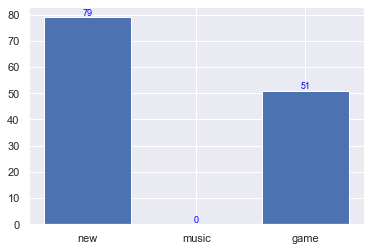

In [25]:
x = ['new', 'music', 'game']
y = [total_category_new_bad, total_category_music_bad, total_category_game_bad]

plt.bar(x, y)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

In [298]:
# 여기서부터
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [299]:
df = pd.read_csv("data/csv/04-26/popular_final_sum.csv")
df2 =  pd.read_csv("data/csv/05-17/popular_final_without_music_sum.csv")
df3 = pd.read_csv("data/csv/05-28/popular_final_without_music_sum.csv")
df2.tail()

,Unnamed: 0,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,category,isBad
3630,3630,Bb5DKSx5jTI,0,슬라이므,"<a href=""https://www.youtube.com/watch?v=Bb5DK...",7:51 옛날에 한??님 자연재해에서 살아남을려고 했던것 같은데...,http://www.youtube.com/channel/UC2fNlqrRiGPJ2I...,0,game,0
3631,3631,Bb5DKSx5jTI,0,노래가사 알려주는사람,배드(bed)락(rock),배드(bed)락(rock),http://www.youtube.com/channel/UCYRsQLlW3OOmXQ...,2,game,0
3632,3632,Bb5DKSx5jTI,1,정하율,아!,아!,http://www.youtube.com/channel/UCf9Zy9XxvlCDYj...,0,game,0
3633,3633,Bb5DKSx5jTI,0,대악마 눈깔대장루피,너무재밌겠다..!!,너무재밌겠다..!!,http://www.youtube.com/channel/UCtIbI1ASGUF1GS...,0,game,0
3634,3634,Bb5DKSx5jTI,0,변규태,호박집ㅋㅋㅋ,호박집ㅋㅋㅋ,http://www.youtube.com/channel/UCgBprHJEiq2RC5...,0,game,0


In [300]:
# new랑 game만 하기로 함

category_new = df[df['category'] == 'new']
category_new2 = df2[df2['category'] == 'new']
category_new3 = df3[df3['category'] == 'new']
category_game = df[df['category'] == 'game']
category_game2 = df2[df2['category'] == 'game']
category_game3 = df3[df3['category'] == 'game']

category_new_bad = category_new[category_new['isBad'] == 1]['isBad'].count()
category_new_bad2 = category_new2[category_new2['isBad'] == 1]['isBad'].count()
category_new_bad3 = category_new3[category_new3['isBad'] == 1]['isBad'].count()

category_game_bad = category_game[category_game['isBad'] == 1]['isBad'].count()
category_game_bad2 = category_game2[category_game2['isBad'] == 1]['isBad'].count()
category_game_bad3 = category_game3[category_game3['isBad'] == 1]['isBad'].count()

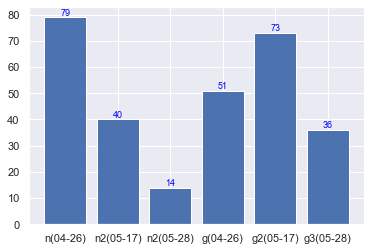

In [301]:
x = ['n(04-26)', 'n2(05-17)', 'n2(05-28)', 'g(04-26)', 'g2(05-17)', 'g3(05-28)']
y = [category_new_bad, category_new_bad2, category_new_bad3, category_game_bad, category_game_bad2, category_game_bad3]

plt.bar(x, y)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()

In [302]:
# 날짜별로 isBad==1인 authorDisplayName를 워드클라우드
isBad_author = df[df['isBad'] == 1]["authorDisplayName"]
isBad_author2 = df2[df2['isBad'] == 1]["authorDisplayName"]
isBad_author3 = df3[df3['isBad'] == 1]["authorDisplayName"]
text_isBad_author = isBad_author.values.tolist()
text_isBad_author2 = isBad_author2.values.tolist()
text_isBad_author3 = isBad_author3.values.tolist()

In [303]:
from collections import Counter

dict_isBad_author = dict(Counter(text_isBad_author))
dict_isBad_author2 = dict(Counter(text_isBad_author2))
dict_isBad_author3 = dict(Counter(text_isBad_author3))

In [304]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud

youtube_mask = np.array(Image.open("wordcloud/youtubemask.png"))

wordcloud = WordCloud(
    font_path='wordcloud/NanumSquareRoundB.ttf', 
    width=800, height=800, background_color='black', mask= youtube_mask
)
wordcloud = wordcloud.generate_from_frequencies(dict_isBad_author)
# wordcloud2 = wordcloud.generate_from_frequencies(dict_isBad_author2)
# wordcloud3 = wordcloud.generate_from_frequencies(dict_isBad_author3)

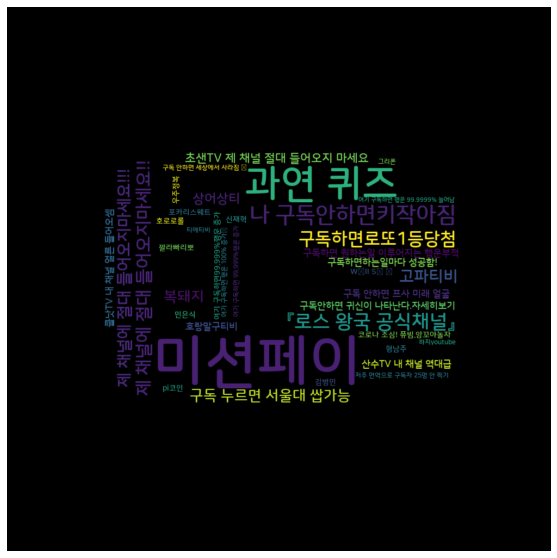

In [305]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.grid(False); plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear") 
plt.show()
# fig.savefig('wordcloud/wordcloud0528.png')

In [306]:
# 날짜별로 isBad==1인 textOriginal 워드클라우드
isBad_textOriginal = df[df['isBad'] == 1]["textOriginal"]
isBad_textOriginal2 = df2[df2['isBad'] == 1]["textOriginal"]
isBad_textOriginal3 = df3[df3['isBad'] == 1]["textOriginal"]
isBad_textOriginal = isBad_textOriginal.values.tolist()
text_isBad_textOriginal2 = isBad_textOriginal2.values.tolist()
text_isBad_textOriginal3 = isBad_textOriginal3.values.tolist()
isBad_textOriginal[:20]

['제 체널에서 무료로 돈버세요~^^',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요~^^',
 "남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로스왕국 ' \n구독=시민권입니다...",
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요~^^',
 "남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로스왕국 ' \n구독=시민권입니다...",
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요~^^',
 '제 체널에서 무료로 돈버세요~^^',
 'https://youtu.be/_ZKl-tZyiRM',
 '구독안하면 영원히 솔로.',
 '구독안하면 영원히 솔로.',
 '제 체널에서 무료로 돈버세요~^^',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요~^^',
 '구독안하면 영원히 솔로.',
 '제 체널에서 무료로 돈버세요~^^',
 "남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로스왕국 ' \n구독=시민권입니다....",
 '구독안하면 영원히 솔로']

In [428]:
import re
# 한글 공백 남김, 자음 모음 제거  
pattern = '[^가-힣 ]|[\t\n\r\f\v]|([ㄱ-ㅎㅏ-ㅣ]+)'
isBad_textOriginal_r = [re.sub(pattern, '', x) for x in isBad_textOriginal]
isBad_textOriginal2_r = [re.sub(pattern, '', x) for x in isBad_textOriginal2]
isBad_textOriginal3_r = [re.sub(pattern, '', x) for x in isBad_textOriginal3]
isBad_textOriginal_r[:10]

['제 체널에서 무료로 돈버세요',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색  로스왕국  구독시민권입니다',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색  로스왕국  구독시민권입니다',
 '구독안하면 영원히 솔로',
 '제 체널에서 무료로 돈버세요',
 '제 체널에서 무료로 돈버세요']

In [309]:
# 한국어 자연어 처리 패키지 konlpy + 속도빠른? Mecab 설치 
from konlpy.tag import Mecab 
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

print(isBad_textOriginal_r[1])
mecab.nouns(isBad_textOriginal_r[1])

구독안하면 영원히 솔로


['구독', '솔로']

In [310]:
is_Bad_nouns = []
for text in isBad_textOriginal_r:
    is_Bad_nouns.extend(list(mecab.nouns(text)))
for text in isBad_textOriginal2_r:
    is_Bad_nouns.extend(list(mecab.nouns(text))) 
for text in isBad_textOriginal3_r:
    is_Bad_nouns.extend(list(mecab.nouns(text)))    
print(is_Bad_nouns[:10])
print(is_Bad_nouns[-10:])

['제', '체', '널', '무료', '돈', '버세', '구독', '솔로', '제', '체']
['샤진', '진심', '방송', '의상', '듯', '내', '수', '좌표', '게', '샤진']


In [311]:
is_Bad_nouns = [x for x in is_Bad_nouns if len(x) > 1]
print(is_Bad_nouns[:10])
print(is_Bad_nouns[-10:])

['무료', '버세', '구독', '솔로', '무료', '버세', '남녀', '갈등', '갈등', '가국']
['샤진', '샤진', '샤진', '샤진', '샤진', '진심', '방송', '의상', '좌표', '샤진']


In [312]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
sns.set()

nouns_counter = Counter(is_Bad_nouns)
top_nouns = dict(nouns_counter.most_common(30))
top_nouns

{'방송': 55,
 '구독': 48,
 '채널': 39,
 '무료': 37,
 '연습생': 36,
 '내유': 35,
 '출신': 34,
 '댓글': 29,
 '아이돌': 24,
 '그룹': 22,
 '하루': 20,
 '샤진': 20,
 '집중': 17,
 '사고': 17,
 '텐션': 17,
 '장난': 17,
 '버세': 16,
 '현질': 16,
 '현직': 16,
 '당신': 15,
 '저주': 15,
 '갈등': 14,
 '행운': 14,
 '프로필': 14,
 '복돼지': 13,
 '가용': 13,
 '솔로': 12,
 '유튜브': 12,
 '수고': 12,
 '방주': 12}

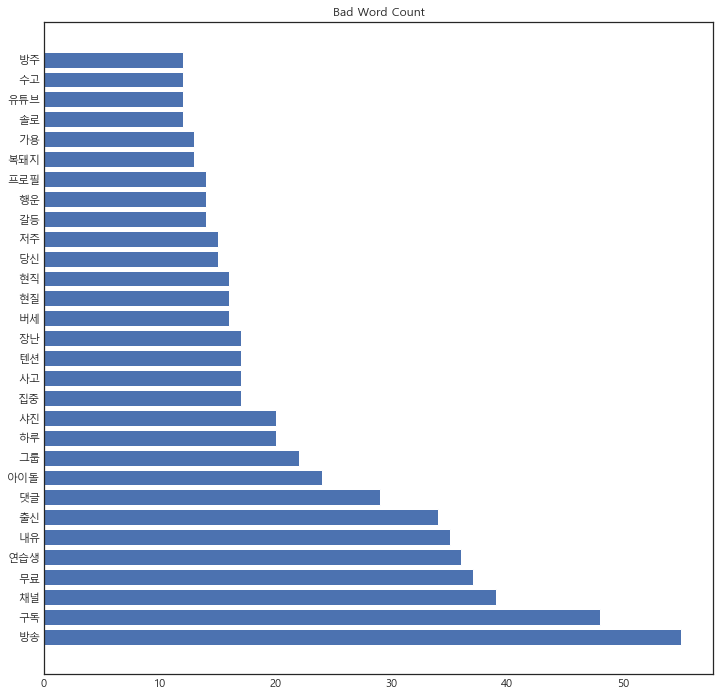

In [313]:
import numpy as np
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 맑은 고딕으로 폰트 설정
matplotlib.rcParams['axes.unicode_minus'] = False #마이너스(-) 폰트 깨짐 방지

y_pos = np.arange(len(top_nouns))

plt.figure(figsize=(12, 12))
plt.barh(y_pos, top_nouns.values())
plt.title('Bad Word Count')
plt.yticks(y_pos, top_nouns.keys())
plt.show()

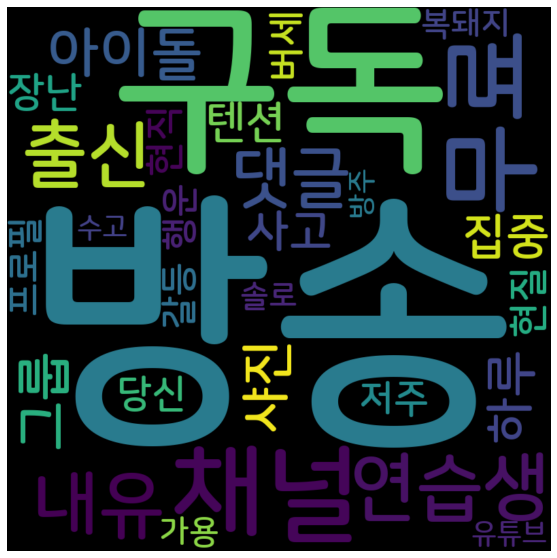

In [314]:
wordcloud = WordCloud(
    font_path='wordcloud/NanumSquareRoundB.ttf', 
    width=800, height=800
)
wordcloud = wordcloud.generate_from_frequencies(top_nouns)

fig = plt.figure(figsize=(10, 10))
plt.grid(False); plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear") 
plt.show()

# CNN 스팸 메일 분류 -> 댓글 분류로???

### 참고
- https://www.youtube.com/watch?v=QejZQ0Dh5x8&list=PL7ZVZgsnLwEEoHQAElEPg7l7T6nt25I3N&index=11

- https://wikidocs.net/22894

In [429]:
# 분류
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [381]:
data = pd.read_csv("data/csv/popular_final_sum.csv")
data["authorAndTextOriginal"] = data["authorDisplayName"] + " " + data["textOriginal"]
data = data.astype({"isBad": 'int',
                    "authorAndTextOriginal" : "str"})
data.head()

,Unnamed: 0,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,category,isBad,authorAndTextOriginal
0,0,K7qKmZn0XfE,0,big k,힘든시기. 연우 하영이<br />보는재미에 푹 빠져<br />잘 지냈습니다<br /...,힘든시기. 연우 하영이\r\n보는재미에 푹 빠져\r\n잘 지냈습니다\r\n그동안 고...,http://www.youtube.com/channel/UCjDN0NP-BJ1WEP...,151.0,new,0,big k 힘든시기. 연우 하영이\r\n보는재미에 푹 빠져\r\n잘 지냈습니다\r\...
1,1,K7qKmZn0XfE,1,미션페이,제 체널에서 무료로 돈버세요~^^,제 체널에서 무료로 돈버세요~^^,http://www.youtube.com/channel/UCXk7WVpUdr9In1...,0.0,new,1,미션페이 제 체널에서 무료로 돈버세요~^^
2,2,K7qKmZn0XfE,0,임충희,경완님 그동안 많이 고마웠어요<br />항상 행복하시고 연우 하영이 모습 자주보여주...,경완님 그동안 많이 고마웠어요\r\n항상 행복하시고 연우 하영이 모습 자주보여주세요...,http://www.youtube.com/channel/UCajvtubq_aEsGh...,669.0,new,0,임충희 경완님 그동안 많이 고마웠어요\r\n항상 행복하시고 연우 하영이 모습 자주보...
3,3,K7qKmZn0XfE,1,과연 퀴즈,구독안하면 영원히 솔로,구독안하면 영원히 솔로,http://www.youtube.com/channel/UCA8pGSJzLLhRtk...,5.0,new,1,과연 퀴즈 구독안하면 영원히 솔로
4,4,K7qKmZn0XfE,0,김남이,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,http://www.youtube.com/channel/UCbt9l09yFRsvy5...,664.0,new,0,김남이 언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금...


In [382]:
# 필요없는 열 삭제
del data["videoId"]
del data["item_type"]
del data["authorDisplayName"]
del data["textDisplay"]
# del data["textOriginal"]
del data["authorChannelUrl"]
del data["likeCount"]
del data["category"]


data[:10]

,Unnamed: 0,textOriginal,isBad,authorAndTextOriginal
0,0,힘든시기. 연우 하영이\r\n보는재미에 푹 빠져\r\n잘 지냈습니다\r\n그동안 고...,0,big k 힘든시기. 연우 하영이\r\n보는재미에 푹 빠져\r\n잘 지냈습니다\r\...
1,1,제 체널에서 무료로 돈버세요~^^,1,미션페이 제 체널에서 무료로 돈버세요~^^
2,2,경완님 그동안 많이 고마웠어요\r\n항상 행복하시고 연우 하영이 모습 자주보여주세요...,0,임충희 경완님 그동안 많이 고마웠어요\r\n항상 행복하시고 연우 하영이 모습 자주보...
3,3,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로
4,4,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,0,김남이 언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금...
5,5,제 체널에서 무료로 돈버세요~^^,1,미션페이 제 체널에서 무료로 돈버세요~^^
6,6,ᆢㅍ#@4@====@Ayden Manuel,0,한은숙 ᆢㅍ#@4@====@Ayden Manuel
7,7,남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로스왕국 ' \r\n구독=...,1,『로스 왕국 공식채널』 남녀갈등/여가부/여야 등 갈등이 없는 가국 유튜브검색 ' 로...
8,8,🌷 🌷 \r\n 🌷 🌷\r\n ...,0,뿌용 🌷 🌷 \r\n 🌷 🌷\r...
9,9,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로


In [383]:
len(data)

12463

In [384]:
import re
# 한글, 공백 제외 영어, 자음, 모음 제거
pattern = '[^가-힣 ]|[\t\n\r\f\v]|([ㄱ-ㅎㅏ-ㅣ]+)'
data["textOriginal"] = data["textOriginal"].map(lambda x : re.sub(pattern, '', x))
data["authorAndTextOriginal"] = data["authorAndTextOriginal"].map(lambda x : re.sub(pattern, '', x))
# 다중 공백 제거
data["textOriginal"] = data["textOriginal"].map(lambda x : re.sub(' +', ' ', x))
data["authorAndTextOriginal"] = data["authorAndTextOriginal"].map(lambda x : re.sub(' +', ' ', x))
data[:10]

,Unnamed: 0,textOriginal,isBad,authorAndTextOriginal
0,0,힘든시기 연우 하영이보는재미에 푹 빠져잘 지냈습니다그동안 고생많이 하셨고요즐거움과 ...,0,힘든시기 연우 하영이보는재미에 푹 빠져잘 지냈습니다그동안 고생많이 하셨고요즐거움과...
1,1,제 체널에서 무료로 돈버세요,1,미션페이 제 체널에서 무료로 돈버세요
2,2,경완님 그동안 많이 고마웠어요항상 행복하시고 연우 하영이 모습 자주보여주세요연우 하...,0,임충희 경완님 그동안 많이 고마웠어요항상 행복하시고 연우 하영이 모습 자주보여주세요...
3,3,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로
4,4,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행복...,0,김남이 언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처...
5,5,제 체널에서 무료로 돈버세요,1,미션페이 제 체널에서 무료로 돈버세요
6,6,,0,한은숙
7,7,남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색 로스왕국 구독시민권입니다,1,로스 왕국 공식채널 남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색 로스왕국 구독...
8,8,꽃길,0,뿌용 꽃길
9,9,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로


In [385]:
len(data)

12463

In [386]:
# 공백 행 제거
data.replace('', np.nan, inplace=True)
data.replace(' ', np.nan, inplace=True)
data.dropna(inplace=True)

In [387]:
len(data)

10356

In [391]:
data[:20]

,Unnamed: 0,textOriginal,isBad,authorAndTextOriginal
0,0,힘든시기 연우 하영이보는재미에 푹 빠져잘 지냈습니다그동안 고생많이 하셨고요즐거움과 ...,0,힘든시기 연우 하영이보는재미에 푹 빠져잘 지냈습니다그동안 고생많이 하셨고요즐거움과...
1,1,제 체널에서 무료로 돈버세요,1,미션페이 제 체널에서 무료로 돈버세요
2,2,경완님 그동안 많이 고마웠어요항상 행복하시고 연우 하영이 모습 자주보여주세요연우 하...,0,임충희 경완님 그동안 많이 고마웠어요항상 행복하시고 연우 하영이 모습 자주보여주세요...
3,3,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로
4,4,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행복...,0,김남이 언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처...
5,5,제 체널에서 무료로 돈버세요,1,미션페이 제 체널에서 무료로 돈버세요
7,7,남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색 로스왕국 구독시민권입니다,1,로스 왕국 공식채널 남녀갈등여가부여야 등 갈등이 없는 가국 유튜브검색 로스왕국 구독...
8,8,꽃길,0,뿌용 꽃길
9,9,구독안하면 영원히 솔로,1,과연 퀴즈 구독안하면 영원히 솔로
11,11,제 체널에서 무료로 돈버세요,1,미션페이 제 체널에서 무료로 돈버세요


In [388]:
# data.drop_duplicates(subset=["textOriginal"], inplace=True)
# len(data)

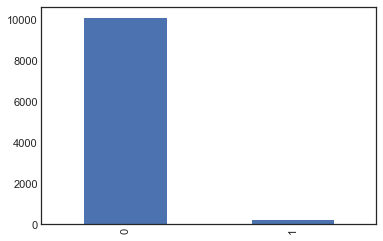

In [389]:
data["isBad"].value_counts().plot(kind="bar")
plt.show()

In [390]:
data.groupby("isBad").size().reset_index(name="count")

,isBad,count
0,0,10095
1,1,261


In [392]:
X_data = data["authorAndTextOriginal"]
Y_data = data["isBad"]

In [393]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [395]:
sequences[:5]

[[220, 11],
 [126, 26, 616, 382, 617],
 [313, 21, 220, 266, 131, 21],
 [656, 764, 221, 116, 697],
 [48, 7, 313, 618, 413, 27]]

In [397]:
X_data = sequences

print('댓글 최대 길이: {}'.format(max(len(l) for l in X_data)))
print('댓글 평균 길이: {}'.format((sum(map(len, X_data))/len(X_data))))

댓글 최대 길이: 181
댓글 평균 길이: 2.9207222865971416


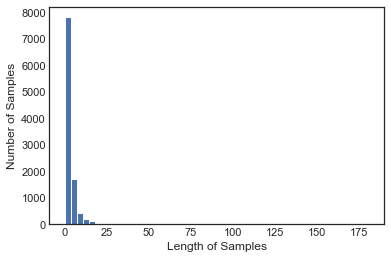

In [399]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [401]:
max_len = 30
data = pad_sequences(X_data, maxlen=max_len)
print(data.shape)

(10356, 30)


In [402]:
 n_train = int(len(sequences) * 0.8)
 n_test = int(len(sequences) - n_train)

 print(n_train)
 print(n_test)

8284
2072


In [403]:
X_train = data[:n_train]
Y_train = np.array(Y_data[:n_train])
X_test = data[n_train:]
Y_test = np.array(Y_data[n_train:])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(8284, 30)
(8284,)
(2072, 30)
(2072,)


In [404]:
# 모델 구성
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [405]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [406]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [407]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks=[es, mc])

Epoch 1/10
104/104 [==============================] - 1s 5ms/step - loss: 0.2369 - acc: 0.9676 - val_loss: 0.1250 - val_acc: 0.9753

Epoch 00001: val_acc improved from -inf to 0.97526, saving model to best_model.h5
Epoch 2/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0911 - acc: 0.9768 - val_loss: 0.0536 - val_acc: 0.9831

Epoch 00002: val_acc improved from 0.97526 to 0.98310, saving model to best_model.h5
Epoch 3/10
104/104 [==============================] - 1s 5ms/step - loss: 0.0376 - acc: 0.9911 - val_loss: 0.0407 - val_acc: 0.9916

Epoch 00003: val_acc improved from 0.98310 to 0.99155, saving model to best_model.h5
Epoch 4/10
104/104 [==============================] - 0s 4ms/step - loss: 0.0304 - acc: 0.9925 - val_loss: 0.0392 - val_acc: 0.9916

Epoch 00004: val_acc did not improve from 0.99155
Epoch 5/10
104/104 [==============================] - 0s 5ms/step - loss: 0.0259 - acc: 0.9934 - val_loss: 0.0355 - val_acc: 0.9916

Epoch 00005: val_acc did not impr

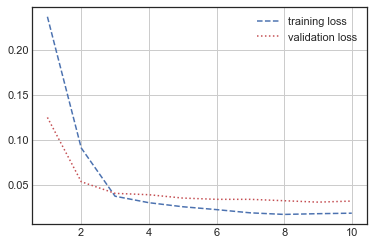

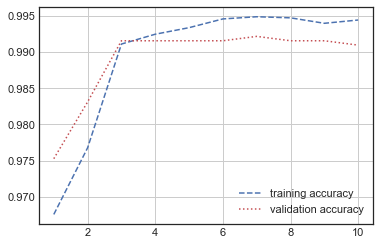

In [411]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='training loss')
plt.plot(epochs, val_loss, 'r:', label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='training accuracy ')
plt.plot(epochs, val_acc, 'r:', label='validation accuracy')
plt.grid()
plt.legend()
plt.show()

In [412]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('best_model.h5')
# loaded_model.evaluate(X_test, Y_test)
model.evaluate(X_test, Y_test)

65/65 [==============================] - 0s 1ms/step - loss: 0.0271 - acc: 0.9923


[0.02709716185927391, 0.992277979850769]

In [437]:
# 모델 예측
from tensorflow.keras.models import load_model
import re

loaded_model = load_model('best_model.h5')
max_len = 30

def predict_comment(new_sentence):
    pattern = '[^가-힣 ]|[\t\n\r\f\v]|([ㄱ-ㅎㅏ-ㅣ]+)'
    new_sentence = re.sub(pattern, '', new_sentence)
    new_token = new_sentence.split()
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen=max_len)
    score = float(loaded_model.predict(new_pad))

    # print("score: ", score)
    if score > 0.5:
        print("-{} -> 나쁨({:.2f}%)".format(new_sentence, score*100))
    else:
        print("{} -> 괜찮음({:.2f}%)".format(new_sentence, (1-score)*100))

In [441]:
predict_comment("과연 퀴즈 구독안하면 영원히 솔로")
predict_comment("미션페이 제 체널에서 무료로 돈버세요")
predict_comment("과연 퀴즈 구독안하면 영원히 솔로")
predict_comment("미션페이 제 체널에서 무료로 돈버세요")
predict_comment("허준범 너무 재밌고")
predict_comment("사주티비 전직 아이돌 출신 비제이 스타킹 개찢는 방송하넹...")
### 여기부터 요즘 꺼
predict_comment("복잡한 엔지니어링 09:54 근래에 본 편집중에 가장 짜릿했습니다. 편집자님.")
predict_comment("제 채널에 절대 들어오지마세요!!! 제 샤진 절대로 보면 안돼요!!")
predict_comment("신진승 와 이게뭐라고 자꾸 듣게되지 미치겠네")

-과연 퀴즈 구독안하면 영원히 솔로 -> 나쁨(95.13%)
-미션페이 제 체널에서 무료로 돈버세요 -> 나쁨(98.34%)
-과연 퀴즈 구독안하면 영원히 솔로 -> 나쁨(95.13%)
-미션페이 제 체널에서 무료로 돈버세요 -> 나쁨(98.34%)
허준범 너무 재밌고 -> 괜찮음(99.95%)
-사주티비 전직 아이돌 출신 비제이 스타킹 개찢는 방송하넹 -> 나쁨(85.85%)
복잡한 엔지니어링  근래에 본 편집중에 가장 짜릿했습니다 편집자님 -> 괜찮음(99.88%)
-제 채널에 절대 들어오지마세요 제 샤진 절대로 보면 안돼요 -> 나쁨(86.47%)
신진승 와 이게뭐라고 자꾸 듣게되지 미치겠네 -> 괜찮음(99.94%)
